## Detectron2 Training

Psuedo-code of what this notebook does

```
for train_json in train_jsons:
    for _ in range(n):
        run training on train_json
        for test_json in test_jsons:
            run evaluation
        report average AP50 on the test_jsons

```

For evaluating, we split the test set into a 3 possibly overlapping subsets and this becomes the list of `test_jsons` the model is evaluated on. 

We also do training and evaluation loop for each `train_json` n times to check the variance in the setup. 

In [1]:
coco_yaml = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
lvis_yaml = "LVIS-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml"
lvis_yaml2 = "LVIS-InstanceSegmentation/mask_rcnn_R_101_FPN_1x.yaml"
pano_yaml = "COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml"

img_dir_test = '/checkpoint/apratik/ActiveVision/active_vision/replica_random_exploration_data/frl_apartment_1/rgb'
# test_json = 'active_vision/frlapt1_10n.json'
test_jsons = ['active_vision/frlapt1_20n0.json', 'active_vision/frlapt1_20n1.json', 'active_vision/frlapt1_20n2.json']

# test_json = 'active_vision/sanity_default_apt0_segn.json' 
# img_dir_test = '/checkpoint/apratik/finals/default/apartment_0/rgb'

img_dir_train = '/checkpoint/apratik/finals/default/apartment_0/rgb'

# img_dir = '/home/locobotm/AVD/habitat_data_with_seg/rgb/'
# train_json = '/home/locobotm/AVD/habitat_data_with_seg/train.json'

# sanity checking 
# train_jsons = [
#     'active_vision/sanity_default_apt0_1n.json',
#     'active_vision/sanity_default_apt0_10n.json',
#     'active_vision/sanity_default_apt0_20n.json',
#     'active_vision/sanity_default_apt0_30n.json',
#     'active_vision/sanity_default_apt0_40n.json',
#     'active_vision/sanity_default_apt0_50n.json',
#     'active_vision/sanity_default_apt0_60n.json',
#     'active_vision/sanity_default_apt0_70n.json',
#     'active_vision/sanity_default_apt0_80n.json',
# ]

# Table 2 - prop fixed, label prop, different GT frames, default heu
train_jsons = [
    'active_vision/default_apt0_gt50p2fix_corln.json',
    'active_vision/default_apt0_gt100p2fix_corln.json',
    'active_vision/default_apt0_gt150p2fix_corln.json',
    'active_vision/default_apt0_gt200p2fix_corln.json',
    'active_vision/default_apt0_gt250p2fix_corln.json',
]

# Table 2 - prop fixed, no label prop, different GT frames
# train_jsons = [
#     'active_vision/base_straightline_apt0_gt50p2fix_corln.json',
#     'active_vision/base_straightline_apt0_gt100p2fix_corln.json',
#     'active_vision/base_straightline_apt0_gt150p2fix_corln.json',
#     'active_vision/base_straightline_apt0_gt200p2fix_corln.json',
#     'active_vision/base_straightline_apt0_gt250p2fix_corln.json',
# ]

# Table 2 - prop fixed, label prop, different GT frames
# train_jsons = [
#     'active_vision/straightline_apt0_gt50p2fix_corln.json',
#     'active_vision/straightline_apt0_gt100p2fix_corln.json',
#     'active_vision/straightline_apt0_gt150p2fix_corln.json',
#     'active_vision/straightline_apt0_gt200p2fix_corln.json',
#     'active_vision/straightline_apt0_gt250p2fix_corln.json',
# ]

# Table 1 - gt fixed, different label prop lengths
# train_jsons = [
#     'active_vision/straightline_apt0_gt100p1_corln.json',
#     'active_vision/straightline_apt0_gt100p2_corln.json',
#     'active_vision/straightline_apt0_gt100p4_corln.json',
#     'active_vision/straightline_apt0_gt100p6_corln.json',
# ]

# train_jsons = [
#     'active_vision/default_apt0_gt100p1_corln.json',
#     'active_vision/default_apt0_gt100p2_corln.json',
#     'active_vision/default_apt0_gt100p4_corln.json',
#     'active_vision/default_apt0_gt100p6_corln.json',
# ]
    

dataset_name = 'habitat_1'

In [4]:
import torchvision

# import some common libraries
import numpy as np
import sys
if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

import cv2
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import random
import os
import numpy as np
import json

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.config import CfgNode as CN
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data import DatasetMapper, build_detection_train_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader, build_detection_train_loader
import detectron2.data.transforms as T
import shutil

import random
import torch 
import base64
import io
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from ast import literal_eval
from PIL import Image
from setuptools.namespaces import flatten

pd.set_option('max_colwidth', 300)

import glob
from IPython.core.display import display, HTML

pd.set_option('max_colwidth', 300)
matplotlib.rcParams['figure.figsize'] = (20, 7.0)

display(HTML(
    """
    <style>
    .container { width:100% !important; }
    #notebook { letter-spacing: normal !important;; }
    .CodeMirror { font-family: monospace !important; }
    .cm-keyword { font-weight: bold !important; color: #008000 !important; }
    .cm-comment { font-style: italic !important; color: #408080 !important; }
    .cm-operator { font-weight: bold !important; color: #AA22FF !important; }
    .cm-number { color: #080 !important; }
    .cm-builtin { color: #008000 !important; }
    .cm-string { color: #BA2121 !important; }
    </style>
    """
))

## Detectron2 Setup

class COCOTrain:
    def __init__(self, lr, w, maxiters):
        self.cfg = get_cfg()
        self.cfg.merge_from_file(model_zoo.get_config_file(coco_yaml))
        self.cfg.SOLVER.BASE_LR = lr  # pick a good LR
        self.cfg.SOLVER.MAX_ITER = maxiters
        self.cfg.SOLVER.WARMUP_ITERS = w
        
    def reset(self, train_json, img_dir_train, dataset_name):
        DatasetCatalog.clear()
        MetadataCatalog.clear()
        self.train_data = dataset_name +  "_train"
        self.train_json = train_json
        register_coco_instances(self.train_data, {}, train_json, img_dir_train)
        self.results = {
            "bbox": {
                "AP50": []
            },
            "segm": {
                "AP50": []
            }
        }
    
    def vis(self):
        dataset_dicts = DatasetCatalog.get(self.train_data)
        for d in random.sample(dataset_dicts, 2):
            img = cv2.imread(d["file_name"])
            visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get(self.train_data), scale=0.5)
            vis = visualizer.draw_dataset_dict(d)
            img = vis.get_image()
            plt.figure(figsize=(12,8))
            plt.imshow(img)
            plt.show()
            
    def train(self):
        cfg = self.cfg
        print(f'SOLVER PARAMS {cfg.SOLVER.MAX_ITER, cfg.SOLVER.WARMUP_ITERS, cfg.SOLVER.BASE_LR}')
        cfg.DATASETS.TRAIN = (self.train_data,)
        cfg.DATASETS.TEST = ()
        cfg.DATALOADER.NUM_WORKERS = 2
        cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(coco_yaml)  # Let training initialize from model zoo
        cfg.SOLVER.IMS_PER_BATCH = 2
        cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128 
        cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(MetadataCatalog.get(self.train_data).get("thing_classes"))  
        cfg.OUTPUT_DIR = os.path.join('output', str(cfg.SOLVER.MAX_ITER), x.split('.')[0][len('active_vision/'):])
        print(f"recreating {cfg.OUTPUT_DIR}")
        if os.path.isdir(cfg.OUTPUT_DIR):
            shutil.rmtree(cfg.OUTPUT_DIR)
        print(cfg.OUTPUT_DIR)
        os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
        self.trainer = DefaultTrainer(cfg) 
        self.trainer.resume_or_load(resume=False)
        self.trainer.train()

    def run_eval(self, dataset_name, test_json, img_dir_test):
        self.val_data = dataset_name + "_val"
        self.test_json = test_json
        self.cfg.DATASETS.TEST = (self.val_data,)
        register_coco_instances(self.val_data, {}, test_json, img_dir_test)
        
        self.evaluator = COCOEvaluator(self.val_data, ("bbox", "segm"), False, output_dir=self.cfg.OUTPUT_DIR)
        self.val_loader = build_detection_test_loader(self.cfg, self.val_data)
        results = inference_on_dataset(self.trainer.model, self.val_loader, self.evaluator)
        self.results['bbox']['AP50'].append(results['bbox']['AP50'])
        self.results['segm']['AP50'].append(results['segm']['AP50'])
        
    def run_train(self, train_json, img_dir_train, dataset_name):
        self.reset(train_json, img_dir_train, dataset_name)
        self.vis()
        self.train()

dataset_name default_apt0_gt50p2fix_corln
829 829
[06/21 22:30:26 d2.data.datasets.coco]: Loaded 200 images in COCO format from active_vision/default_apt0_gt50p2fix_corln.json


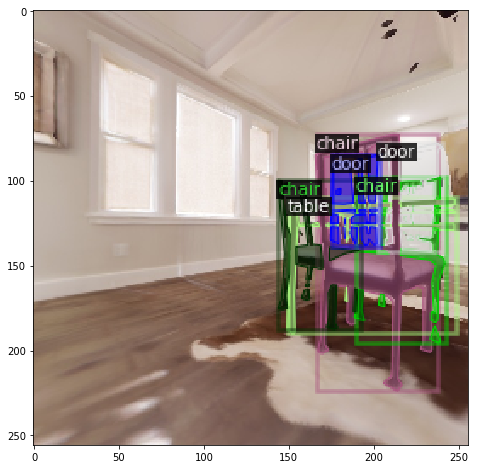

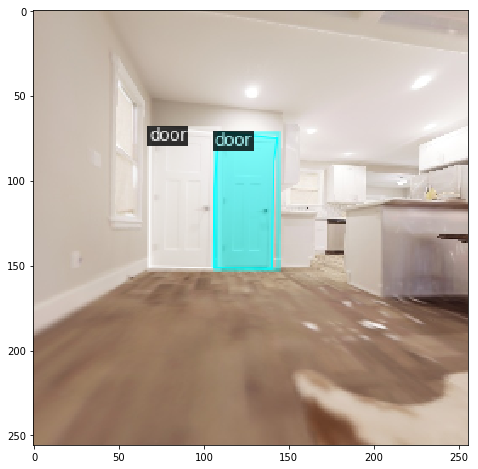

SOLVER PARAMS (50, 100, 0.001)
recreating output/50/default_apt0_gt50p2fix_corln
output/50/default_apt0_gt50p2fix_corln
[06/21 22:30:28 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2),

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (6, 256, 1, 1) 

[06/21 22:30:28 d2.engine.train_loop]: Starting training from iteration 0
[06/21 22:30:33 d2.utils.events]:  eta: 0:00:06  iter: 19  total_loss: 3.342  loss_cls: 1.512  loss_box_reg: 0.8011  loss_mask: 0.6909  loss_rpn_cls: 0.1676  loss_rpn_loc: 0.1367  time: 0.2316  data_time: 0.0119  lr: 0.00019081  max_mem: 2879M
[06/21 22:30:38 d2.utils.events]:  eta: 0:00:02  iter: 39  total_loss: 2.454  loss_cls: 0.7328  loss_box_reg: 0.7722  loss_mask: 0.6229  loss_rpn_cls: 0.1086  loss_rpn_loc: 0.1017  time: 0.2299  data_time: 0.0038  lr: 0.00039061  max_mem: 2879M
[06/21 22:30:41 d2.utils.events]:  eta: 0:00:00  iter: 49  total_loss: 2.379  loss_cls: 0.7146  loss_box_reg: 0.8071  loss_mask: 0.6017  loss_rpn_cls: 0.1025  loss_rpn_loc: 0.07112  time: 0.2305  data_time: 0.0038  lr: 0.00049051  max_mem: 2879M
[06/21 22:30:41 d2.engine.hooks]: Overall training speed: 48 iterations in 0:00:11 (0.2305 s / it)
[06/21 22:30:41 d2.engine.hooks]: Total training time: 0:00:12 (0:00:01 on hooks)
1832 1832


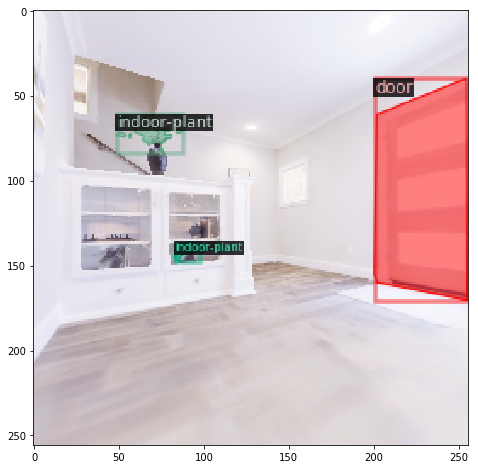

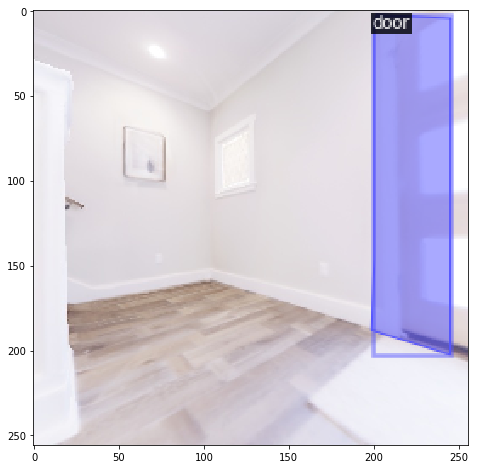

SOLVER PARAMS (50, 100, 0.001)
recreating output/50/default_apt0_gt100p2fix_corln
output/50/default_apt0_gt100p2fix_corln
[06/21 22:33:33 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (6, 256, 1, 1) 

[06/21 22:33:34 d2.engine.train_loop]: Starting training from iteration 0
[06/21 22:33:39 d2.utils.events]:  eta: 0:00:06  iter: 19  total_loss: 3.882  loss_cls: 1.812  loss_box_reg: 0.8383  loss_mask: 0.6888  loss_rpn_cls: 0.256  loss_rpn_loc: 0.1523  time: 0.2306  data_time: 0.0114  lr: 0.00019081  max_mem: 2879M
[06/21 22:33:43 d2.utils.events]:  eta: 0:00:02  iter: 39  total_loss: 2.576  loss_cls: 0.7898  loss_box_reg: 0.7446  loss_mask: 0.6411  loss_rpn_cls: 0.1269  loss_rpn_loc: 0.1663  time: 0.2316  data_time: 0.0036  lr: 0.00039061  max_mem: 2879M
[06/21 22:33:47 d2.utils.events]:  eta: 0:00:00  iter: 49  total_loss: 2.494  loss_cls: 0.6852  loss_box_reg: 0.6763  loss_mask: 0.587  loss_rpn_cls: 0.121  loss_rpn_loc: 0.2575  time: 0.2335  data_time: 0.0036  lr: 0.00049051  max_mem: 2879M
[06/21 22:33:47 d2.engine.hooks]: Overall training speed: 48 iterations in 0:00:11 (0.2335 s / it)
[06/21 22:33:47 d2.engine.hooks]: Total training time: 0:00:12 (0:00:00 on hooks)
1832 1832
[06/

KeyboardInterrupt: 

In [7]:

maxiters = 50
lr = [0.001, 0.002, 0.005, 0.01, 0.02]
warmup = [100, 200]

def write_summary_to_file(filename, results, header_str):
    if isinstance(results['bbox']['AP50'][0], list):
        results['bbox']['AP50'] = list(flatten(results['bbox']['AP50']))
        results['segm']['AP50'] = list(flatten(results['segm']['AP50']))
    with open(filename, "a") as f:
            f.write(header_str)
            f.write(f"\nbbox AP50 {sum(results['bbox']['AP50'])/len(results['bbox']['AP50'])}")
            f.write(f"\nsegm AP50 {sum(results['segm']['AP50'])/len(results['segm']['AP50'])}")
            f.write(f'\nall results {results}')
            
def main_loop(train_json, n):
    results = {
        "bbox": {
            "AP50": []
        },
        "segm": {
            "AP50": []
        }
    }
    for _ in range(n):
        c = COCOTrain(lr[0], warmup[0], maxiters)
        dataset_name = x.split('.')[0][len('active_vision/'):]
        print(f'dataset_name {dataset_name}')
        c.run_train(train_json, img_dir_train, dataset_name)
        for yix in range(len(test_jsons)):
            c.run_eval(str(yix), test_jsons[yix], img_dir_test)
        print(f'all results {c.results}')
        results['bbox']['AP50'].append(c.results['bbox']['AP50'])
        results['segm']['AP50'].append(c.results['segm']['AP50'])
        write_summary_to_file('results_granular.txt', c.results, f'\ntrain_json {x}')

    write_summary_to_file('results_averaged.txt', results, f'\ntrain_json {train_json}, average over {n} runs')
   
            
for x in train_jsons:
    main_loop(x, 1)
    